In [1]:
import numpy as np
import matplotlib.pyplot as plt
from EMAN2 import *

In [2]:
#### select one GPU when multiple GPUs are present
os.environ["CUDA_VISIBLE_DEVICES"]='0' 

#### do not occupy the entire GPU memory at once
##   seems necessary to avoid some errors...
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"]='true' 

#### finally initialize tensorflow
import tensorflow as tf

In [3]:
#### we will import some functions from e2gmm_refine later
emdir=e2getinstalldir()
sys.path.insert(0,os.path.join(emdir,'bin'))

#### need to unify the float type across tenforflow and numpy
##   in theory float16 also works but it can be unsafe especially when the network is deeper...
floattype=np.float32

In [4]:
#### load particles and prepare some parameters
from e2gmm_refine import load_particles, set_indices_boxsz
fname="r3d_00/ptcls_01.lst"

##  Fourier box size. will shrink particles accordingly
maxboxsz=48 

##   load metadata first
e=EMData(fname, 0, True)
raw_apix, raw_boxsz = e["apix_x"], e["ny"]
data_cpx, xfsnp = load_particles(fname, maxboxsz, shuffle=False)

print("Image size: ", data_cpx[0].shape)

##   set up fourier indices for image generation/clipping later
##   params is a dictionay that saves matrices for Fourier indexing
apix=raw_apix*raw_boxsz/maxboxsz
clipid=set_indices_boxsz(data_cpx[0].shape[1], apix, True)
params=set_indices_boxsz(maxboxsz)

##   create an empty options object that is needed for some functions in e2gmm_refine
options=type('options', (object,), {})()
options.sym="c1"

Loading 3000 particles of box size 128. shrink to 48
3000/3000      
Data read complete
Image size:  (3000, 48, 25)


In [5]:
#### load the Gaussian model produced by e2gmm_refine.py
from e2gmm_refine import get_clip

pts=np.loadtxt("gmm_00/model_gmm.txt").astype(floattype)
print("Gaussian model shape: ", pts.shape)

##   turn model to tensorflow format
pts=tf.constant(pts[None,:,:])

Gaussian model shape:  (1590, 5)


0.31638232


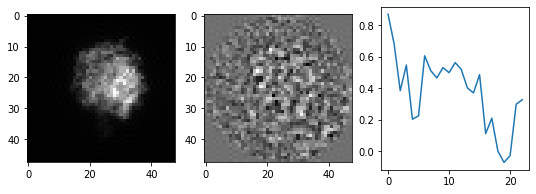

In [6]:
#### now generate some images to make sure everything is working properly
from e2gmm_refine import pts2img, calc_frc

sz=params["sz"]    ## size of image
bsz=8              ## batch size

##   generate a batch of projection images from the GMM at neutral state
##   pts2img produce complex images in (real, imag) format
##   turn them into complex numbers and IFT to get the real images
ptsx=tf.Variable(tf.repeat(pts, bsz, axis=0))
imgs_real, imgs_imag=pts2img(ptsx, xfsnp[:bsz], params, lp=.05)
imgs_cpx=imgs_real.numpy().astype(floattype)+1j*imgs_imag.numpy().astype(floattype)
imgs_out=np.fft.irfft2(imgs_cpx)

##   just show one projection-particle comparison
ii=1
plt.figure(figsize=(9,3))
plt.subplot(1,3,1)
plt.imshow(imgs_out[ii], cmap='gray')

##   get the complex particle image and IFT to real space
dcpx=(data_cpx[0][:bsz], data_cpx[1][:bsz])
dcpx=get_clip(dcpx, sz, clipid)
dcpx_out=np.fft.irfft2(dcpx[0].numpy()+1j*dcpx[1].numpy())

plt.subplot(1,3,2)
plt.imshow(dcpx_out[ii], cmap='gray')

##   calculate FRC between particle and projection
##   the calc_frc function takes complex images in (real, imag) format
frc=calc_frc(dcpx, (imgs_real, imgs_imag), params["rings"], True)
plt.subplot(1,3,3)
plt.plot(frc[ii][1:])
fval=calc_frc(dcpx, (imgs_real, imgs_imag), params["rings"])
print(np.mean(fval))

Instructions for updating:
Use tf.identity instead.
 375/375 : 0.3039         mean score: 0.316


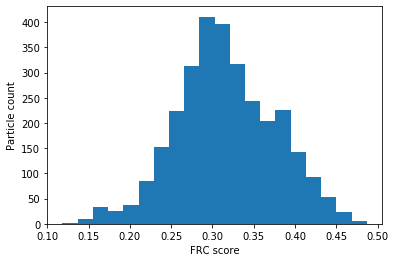

In [7]:
#### calculate d(FRC)/d(GMM) for each particle
##   this will be the input for the deep network in place of the particle images
from e2gmm_refine import calc_gradient

##   shrink particles to the requested size
dcpx=get_clip(data_cpx, params["sz"], clipid)

##   prepare training set to be fed into the function
trainset=tf.data.Dataset.from_tensor_slices((dcpx[0], dcpx[1], xfsnp))
trainset=trainset.batch(bsz)
allscr, allgrds=calc_gradient(trainset, pts, params, options)

##   histogram FRC for each particle
plt.hist(allscr, 20);
plt.xlabel("FRC score");
plt.ylabel("Particle count");

In [8]:
#### now build the deep networks and do some test
from e2gmm_refine import build_encoder, build_decoder

nmid=4     ## size of latent space
conv=True  ## convolution mode, should be more powerful

##   build the actual network
encode_model=build_encoder(nout=nmid, conv=conv)
decode_model=build_decoder(pts[0].numpy(), ninp=nmid, conv=conv)

##   test the network to make sure they are function properly
##   before training, they should output GMMs that are very close to the neutral GMM
mid=encode_model(allgrds[:bsz])
print("Latent space shape: ", mid.shape)
out=decode_model(mid)
print("Output shape: ",out.shape)
print("Deviation from neutral model: ", np.mean(abs(out-pts)))


Latent space shape:  (8, 4)
Output shape:  (8, 1590, 5)
Deviation from neutral model:  7.2705006e-06


In [9]:
#### train the network from the particles
from e2gmm_refine import train_heterg

##   parse parameters as options
options.niter=10                ## number of iterations
options.pas=[0,1,0]             ## mask the (position, amplitude, sigma) of the GMM during training
options.learnrate=1e-4          ## learning rate
ptclidx=allscr>-1               ## this allows the selection of a subset of particles for training. now used now

##   actual training
trainset=tf.data.Dataset.from_tensor_slices((allgrds[ptclidx], dcpx[0][ptclidx], dcpx[1][ptclidx], xfsnp[ptclidx]))
trainset=trainset.batch(bsz)

train_heterg(trainset, pts, encode_model, decode_model, params, options)

iter 0, loss : -0.3258  
iter 1, loss : -0.3392  
iter 2, loss : -0.3450  
iter 3, loss : -0.3482  
iter 4, loss : -0.3506  
iter 5, loss : -0.3530  
iter 6, loss : -0.3550  
iter 7, loss : -0.3569  
iter 8, loss : -0.3588  
iter 9, loss : -0.3605  


(3000, 4)


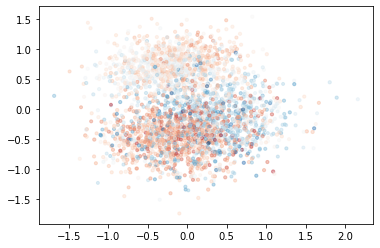

In [10]:
#### compute the conformation of each particle
from e2gmm_refine import calc_conf

##   this is a 4D latent space and can be hard to visualize
mid=calc_conf(encode_model, allgrds[ptclidx])
print(mid.shape)
plt.scatter(mid[:,0], mid[:,1], mid[:,2]+10, mid[:,3]+1, alpha=.4, cmap="RdBu");

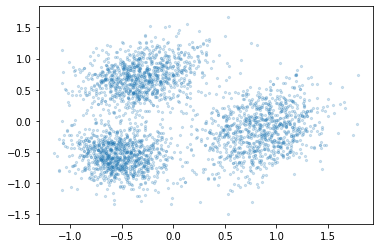

In [11]:
#### do pca on the latent space for better visualization
from sklearn.decomposition import PCA

pca=PCA(2)
p2=pca.fit_transform(mid)
plt.scatter(p2[:,0], p2[:,1],s=5,  alpha=.2);

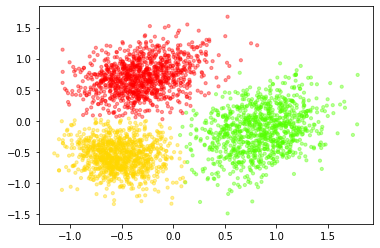

In [12]:
#### classify particles from PCA space
from sklearn import mixture
clust = mixture.GaussianMixture(3)
lbs=clust.fit_predict(p2[:,:2])

plt.scatter(p2[:,0], p2[:,1],s=10, c=lbs, alpha=.4, cmap="prism");

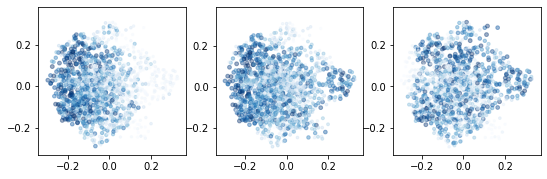

In [13]:
#### plot GMM for each class
cnt=clust.means_     ## start from class centers
cnt=pca.inverse_transform(cnt)     ## inverse PCA to back to the neural network latent space
pcnt=decode_model(cnt.astype(floattype))    ## go through the decoder to get the Gaussian model
pcnt=pcnt.numpy()

plt.figure(figsize=(9,3))
for i,p in enumerate(pcnt):
    plt.subplot(1,3,i+1)
    plt.scatter(pts[0,:,0], pts[0,:,1], s=p[:,3]*10+5, c=p[:,3]*10, alpha=.4, cmap="Blues")
    plt.axis("square")

In [14]:
#### generate particles subsets from classification
from EMAN2_utils import load_lst_params, save_lst_params
ptclinfo=load_lst_params(fname)


for l in np.unique(lbs):
    cls=(lbs==l)
    psave=[p for i,p in enumerate(ptclinfo) if cls[i]]
    print("Class {} : {} particles".format(l, len(psave)))
    save_lst_params(psave, "gmm_00/ptcl_cls_{:02d}.lst".format(l))

Class 0 : 1016 particles
Class 1 : 1003 particles
Class 2 : 981 particles


In [15]:
#### reconstruct particles for each class
for i in range(3):
    launch_childprocess("e2make3dpar.py --input gmm_00/ptcl_cls_{:02d}.lst --output gmm_00/threed_cls_{:02d}.hdf --pad 168 --mode trilinear --no_wt --keep 1 --threads 12 --setsf strucfac.txt".format(i,i))

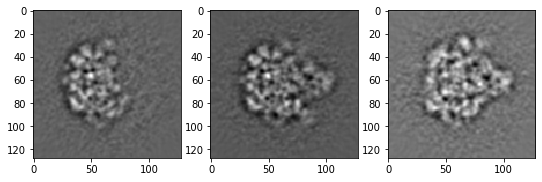

In [16]:
#### look at the 3d map from each class
##   this should be similar to the Gaussian model of each class
plt.figure(figsize=(9,3))

for i in range(3):
    e=EMData("gmm_00/threed_cls_{:02d}.hdf".format(i))
    e=e.numpy().copy()
    e=np.mean(e, axis=0)
    plt.subplot(1,3,i+1)
    plt.imshow(e, cmap='gray')